In [1]:
import sys
import ctypes

import cv2
import skimage.io as io
import skimage.transform as T
import numpy as np
from scipy.misc import face
import matplotlib.pyplot as plt
from IPython import display
from moviepy.editor import VideoClip, VideoFileClip
from IPython.display import Video as IPythonVideo
from ntsc_py.snes_ntsc import SNES_NTSC, PALETTE, rgb2nes, nes2rgb

## Video Structures

In [2]:
class FrameIterator:
    def __init__(self, frames):
        self.i = 0
        self.frames = frames

    def __call__(self, *args, **kwargs):
        frame = self.frames[self.i]
        if self.i < len(self.frames) - 1:
            self.i = self.i + 1
        return frame

In [3]:
def save_frames(path, frames, fps=30):
    clip = VideoClip(FrameIterator(frames), duration=(len(frames) / fps))
    clip = clip.set_fps(fps)
    clip.write_videofile(path)

## Load Filter

In [4]:
h = NES_NTSC(mode='composite', flicker=True)

In [5]:
h.nes_pixels.dtype, h.nes_pixels.shape

(dtype('uint8'), (240, 256, 1))

In [6]:
h.ntsc_pixels.dtype, h.ntsc_pixels.shape

(dtype('uint8'), (240, 602, 3))

## NES Palette

In [7]:
imgs = []
for rgb in PALETTE:
    img = np.zeros((128, 128, 3), dtype=np.uint8)
    img[:] = rgb
    imgs.append(img)
imgs = np.array(imgs)
# convert the images to a matrix of of images
imgs = np.array(imgs).reshape((4, 16, 128, 128, 3))
# swap the axis at index 1 and 2 and concatenate
# axis 0 to combine the rows of images
imgs = np.moveaxis(imgs, 1, 2)
imgs = np.concatenate(imgs, axis=0)
# swap axis 0 with 1, then 1 with 2 and concatenate
# axis 0 to combine the columns of images
imgs = np.moveaxis(np.moveaxis(imgs, 0, 1), 1, 2)
imgs = np.concatenate(imgs, axis=0)
# transpose the image back to the normal dimensions
imgs = np.moveaxis(imgs, 0, 1)
imgs.shape

(512, 2048, 3)

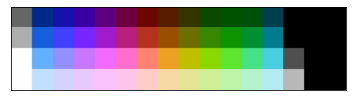

In [8]:
ax = plt.imshow(imgs)
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())

### Lossy Encode RGB Image

In [9]:
H, W, C = h.nes_pixels.shape

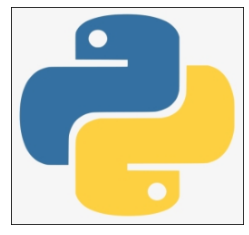

In [10]:
# img = 
# img = T.resize(face(), (H, W), preserve_range=True).round().astype(int)
img = T.resize(io.imread('python.png'), (H, W), preserve_range=True).round().astype(int)[..., :3]
ax = plt.imshow(img)
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())

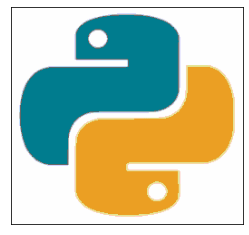

In [11]:
h.nes_pixels[:] = rgb2nes(img)
ax = plt.imshow(nes2rgb(h.nes_pixels[..., 0]))
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())

## Input Buffer

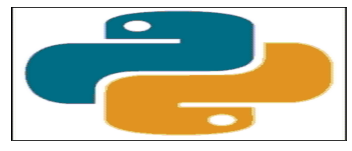

In [12]:
h.process()
ax = plt.imshow(h.ntsc_pixels)
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())
plt.show()

## Process Output

In [13]:
# for i in range(60):
#     h.process()
#     display.clear_output(wait=True)
#     ax = plt.imshow(h.ntsc_pixels)
#     ax.axes.xaxis.set_major_locator(plt.NullLocator())
#     ax.axes.yaxis.set_major_locator(plt.NullLocator())
#     plt.show()

## Adjust Parameters

In [14]:
frames = []
for i in range(400):
    h.setup(
        hue=i/200 - 1, 
        saturation=i/2 - 1, 
        contrast=i/200 - 1, 
        brightness=i/200 - 1, 
        sharpness=i/200 - 1, 
        gamma=i/200 - 1,
        artifacts=20 * i - 1,
        fringing=i/200 - 1,
        bleed=i/200 - 1,
    )
    cv2.putText(h.nes_pixels, 'NES', (35, 90), cv2.FONT_HERSHEY_SIMPLEX, 3, (0x3f, ), 3)
    cv2.putText(h.nes_pixels, 'NTSC', (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 3, (0x3f, ), 3)
    # step the filter
    h.process()
    shape = list(h.ntsc_pixels.shape)
    shape[1] = shape[1] / 2
    output = T.resize(h.ntsc_pixels, shape, preserve_range=True)
    frames.append(output.round().astype('uint8'))
frames = frames[50:]

In [15]:
path = 'nes-ntsc.mp4'
save_frames(path, frames)
IPythonVideo(path, embed=True)

t:  19%|█▉        | 68/350 [00:00<00:00, 668.28it/s, now=None]

Moviepy - Building video nes-ntsc.mp4.
Moviepy - Writing video nes-ntsc.mp4



Moviepy - Done !
Moviepy - video ready nes-ntsc.mp4


In [16]:
video = VideoFileClip(path)
# video = video.subclip((0, 50), (1, 10))
video = video.set_fps(1)
# video = video.resize(0.5)
video.write_gif(path.replace('.mp4', '.gif'))

t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]

MoviePy - Building file nes-ntsc.gif with imageio.
